# MUSES Calculation Engine Tutorial

## Introduction

This notebook will show you how to run a single-module workflow using the MUSES Calculation Engine (CE). It is designed such that each cell can be manually executed after reading and following the instructions.

While this tutorial relies heavily on the `CalculationEngineApi` class to provide a Python interface to the RESTful API, you are encouraged to read the technical API specs at https://ce.musesframework.io/swagger-ui, where you can also experiment with the API interactively after logging in at https://ce.musesframework.io.

⚠️ **IMPORTANT: this notebook requires libraries from [calculation_engine_api.py](https://gitlab.com/nsf-muses/calculation-engine/-/blob/main/app/calculation_engine/tests/calculation_engine_api.py?ref_type=heads); you to download this file and place it in the same repository as this notebook.**  
  
👉 You can also run the notebook through a **MUSES JupyterHub instance**; you will need to [request access explicitly](https://forum.musesframework.io/t/request-access-to-muses-jupyterhub/1564) on our forum, which **we do encourage you to try!**

In [2]:
import os
import yaml
import logging
import getpass
import time

from calculation_engine_api import CalculationEngineApi

### Configure connection settings

🛑 **STOP! Before you proceed, please follow the steps in the [Quick Start guide](https://musesframework.io/docs/user/quickstart.html) to ensure that you have a MUSES account and that you are properly logged into the [Calculation Engine](https://ce.musesframework.io).**

Press the green **API Token** button on the [Calculation Engine web app](https://ce.musesframework.io/) and enter your token at the prompt.

It should look like `ae9e48be14efbaabcdd90b44a3505b94d52b2c25`.

🛈 If you are running locally in Docker Compose, you do not need to provide a token because the local admin account will be used instead.

In [3]:
# Set environment variables
if os.getenv('RUNNING_IN_DOCKER', '') == 'true':
    os.environ['CE_API_URL_PROTOCOL'] = 'http'
    os.environ['CE_API_URL_AUTHORITY'] = 'api-proxy:4000'
else:
    os.environ['LOG_LEVEL'] = str(logging.INFO)
    os.environ['CE_API_URL_PROTOCOL'] = 'https'
    os.environ['CE_API_URL_AUTHORITY'] = 'ce.musesframework.io'
    os.environ['CE_API_TOKEN'] = getpass.getpass()

 ········


### Obtain an API object to interact with the Calculation Engine

In [4]:
api = CalculationEngineApi()

## Single-module workflow example: Ising - 2D T'-expansion Scheme

### Define your workflow
Here, you need to specify the module you want to use. To find the name of the corresponding module of interest, check the list of [available modules on the CE](https://ce.musesframework.io/ce/modules/).  
Once the module chosen, check out the associated documentation for the config variables; for this tutorial, see the [Ising-2DTExS documentation](https://ce.musesframework.io/docs/modules/eos_ising_texs_2d/_contents/parameters.html) page, or the [module's API specifications](https://gitlab.com/nsf-muses/module-ising-eos/ising_eos/-/blob/main/api/OpenAPI_Specifications-IsingTExS_EoS.yaml?ref_type=heads) for more detailed information.

In order to know what physical parameters to choose (*in this specific case the critical point parameters $\alpha_{12}$, $w$ and $\rho$*), one can have a look at the [related publication](https://arxiv.org/pdf/2402.08636) to get guidance. For this example, we employ parameters used to obtain Figs. 5-6.

In [7]:
wf_config = yaml.safe_load('''
    processes:
        - name: ising-2dtexs
          module: eos_ising_texs_2d
          config:
            parameters:
                T_min: 30.0
                T_max: 400.0
                dT: 10.0
                mu_B_min: 0.0
                mu_B_max: 700.0
                dmu_B: 10.0
                muBC: 350.0
                alpha12: 90.0
                w: 2.0
                rho: 2.0
            switchers:
                get_P: True
                get_s_dens: True
                get_B_dens: True
                get_E_dens: True
    components:
      - type: group
        name: run_ising-2dtexs
        group:
          - ising-2dtexs
''')

### Launch a job to run the workflow

Once your workflow is defined, you can submit a job to our cluster through:

In [8]:
job_response = api.job_create(
    description='Tutorial job',
    name= 'Tutorial. Ising-2DTExS',
    config={
    "workflow": {
        "config": wf_config
    }
})
try:
    job_id = job_response['uuid']
except:
    print(f'''HTTP {job_response.status_code} {job_response.text}''')

### Query the status of the job

You can check the status of the job either through: 
1. the [Calculation Engine](https://ce.musesframework.io), by logging in and checking the "[Jobs](https://ce.musesframework.io/ce/jobs/)": 
  
   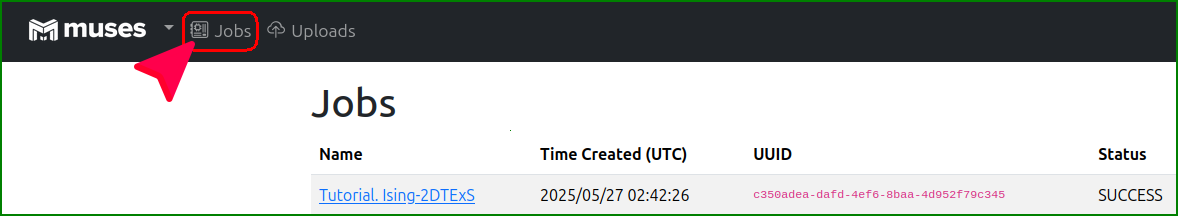  

2. using the following piece of code:

In [9]:
print('The job has ID ', job_id)

while True:
    job_status = api.job_list(uuid=job_id)
    print('\tStatus: ', job_status['status'])
  
    if job_status['status'] in ['SUCCESS', 'FAILURE']:
        break  # Exit the loop if the job is done

    time.sleep(10)  # Adjust the check delay as necessary


The job has ID  85ca6cf0-ae72-4b3f-9a59-21908a6fd9e3
	Status:  SUCCESS


### Download the job output files

1. You can access the jobs run through the Calculation Engine web app, under "**Jobs**", and download the output files from there:  

    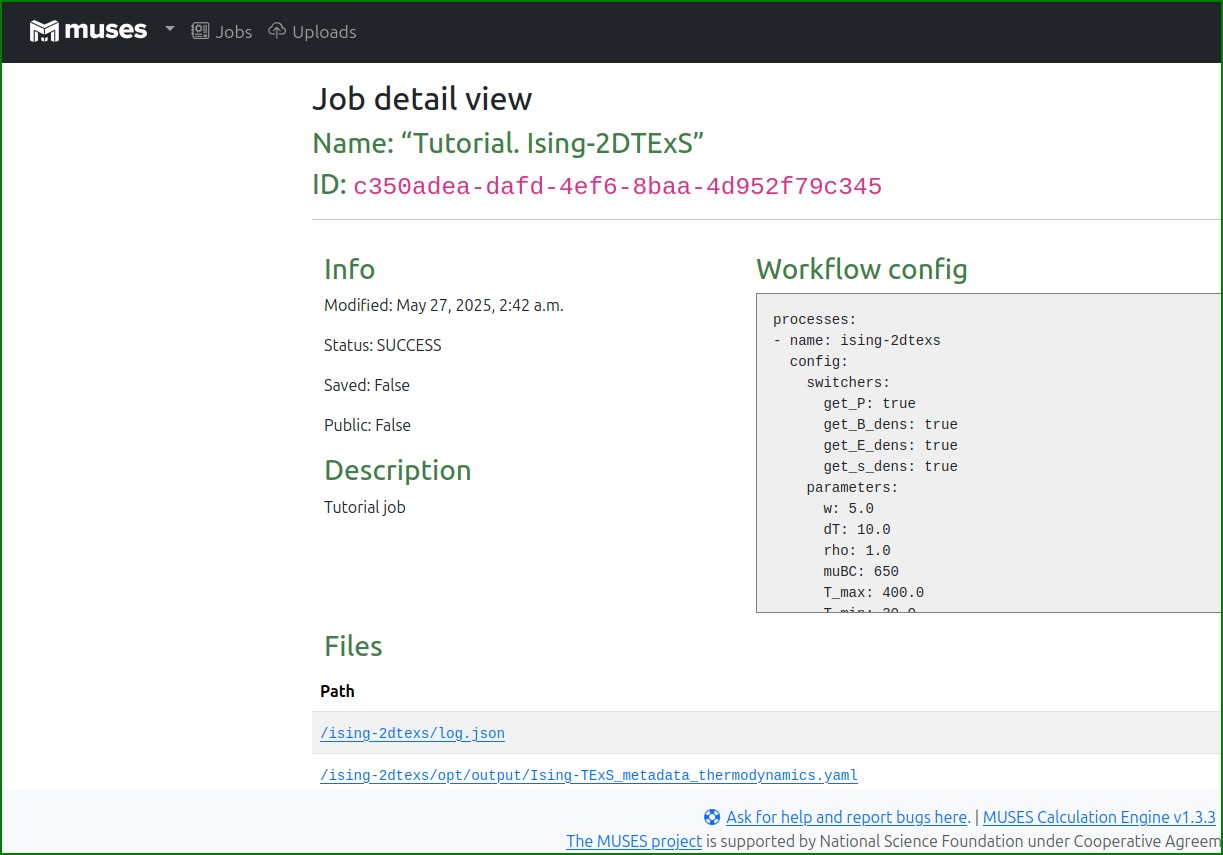  
  
2. You can also download them locally on the JupyterHub / your local machine using the following:

In [10]:
output_dir='./downloads/jobs/'
job_info = api.job_list(uuid=job_id)
print(f'''Downloading job output files. Saving into {os.path.join(output_dir,job_id)}''')
for file_info in job_info['files']:
    if file_info['size'] > 0:
        print(f'''  "{file_info['path']}"...''')
        api.download_job_file(job_id, file_info['path'], root_dir=output_dir)
    else:
        print(f'''  WARNING: Skipping zero-length file "{file_info['path']}"''')

  "/ising-2dtexs/log.json"...
  "/ising-2dtexs/opt/output/Ising-TExS_metadata_thermodynamics.yaml"...
  "/ising-2dtexs/opt/output/Ising-TExS_output_thermodynamics.csv"...
  "/ising-2dtexs/opt/output/status.yaml"...
  "/ising-2dtexs/opt/output/valid_config.yaml"...
  "/meta.yaml"...
  "/workflow.yaml"...


### Save a job and make it available for others to use

Jobs expire after some time to conserve our storage capacity and ensure fair use of the system. You can save a limited number of jobs to prevent them from being automatically deleted. Additionally, you can mark jobs as public so that other may use the output as inputs to their workflows.

The example below shows how you can save a job and make it public in a single API call (`PATCH /api/v0/ce/job/{id}/`).

In [ ]:
# Fetch the current job state
job_info = api.job_list(uuid=job_id)
saved = "NOT " if not job_info['saved'] else ''
public = "NOT " if not job_info['public'] else ''
print(f'''(before update) Job {job_id} is {public}public and {saved}saved.''')

# Set the job public and saved state to the opposite of whatever it is currently
api.update_job(job_id, saved=not job_info['saved'], public=not job_info['public'])
job_info = api.job_list(uuid=job_id)
saved = "NOT " if not job_info['saved'] else ''
public = "NOT " if not job_info['public'] else ''
print(f'''(after update) Job {job_id} is {public}public and {saved}saved.''')